In [18]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import itertools
import random
import seaborn as sns
import re
from tqdm import tqdm
from simulate_battery import get_battery_simulation

In [19]:
def grouper(iterable, n, fillvalue=None):
    "Collect data into fixed-length chunks or blocks"
    # grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"
    args = [iter(iterable)] * n
    return itertools.zip_longest(*args, fillvalue=fillvalue)

# Load the data

In [20]:
data_dir = os.path.abspath('../data')
data_path = os.path.join(data_dir, 'dfE_300s.hdf')

In [21]:
raw_input_df = pd.read_hdf(data_path)

In [22]:
raw_input_df

,E_dehumidifier_power,E_dishwasher_power,E_gasheating_pump_power,E_total_cons_power,E_prod_power,E_solarheating_pump_power,E_tumble_dryer_power,E_washing_machine_power
2016-12-01 00:00:00,2.350,0.0,43.560,159.0,0.0,1.2000,0.0,0.0
2016-12-01 00:05:00,2.316,0.0,39.440,134.0,0.0,1.2080,0.0,0.0
2016-12-01 00:10:00,2.312,0.0,47.298,132.0,0.0,1.2120,0.0,0.0
2016-12-01 00:15:00,2.324,0.0,47.806,136.0,0.0,1.2040,0.0,0.0
2016-12-01 00:20:00,2.340,0.0,48.158,136.0,0.0,1.2100,0.0,0.0
...,...,...,...,...,...,...,...,...
2019-07-30 23:40:00,0.000,0.0,0.000,161.0,0.0,1.3000,0.0,0.0
2019-07-30 23:45:00,0.000,0.0,0.000,187.0,0.0,1.2620,0.0,0.0
2019-07-30 23:50:00,0.000,0.0,0.000,197.0,0.0,1.2600,0.0,0.0
2019-07-30 23:55:00,0.000,0.0,0.000,116.0,0.0,1.2620,0.0,0.0


In [23]:
column_mapping = {}
for c in raw_input_df.columns:
    if c in column_mapping:
        continue
    m = re.match(r'^[A-Z]_(\w+)$', c)
    if m is None:
        raise RuntimeError('Unsupported column name format {}. You will have to map the column manually.'.format(c))
    if m[1] == 'prod_power':
        column_mapping[c] = 'exp_power'
    else:
        column_mapping[c] = m[1]
input_df = raw_input_df.rename(columns=column_mapping)
input_df.columns

Index(['dehumidifier_power', 'dishwasher_power', 'gasheating_pump_power',
       'total_cons_power', 'exp_power', 'solarheating_pump_power',
       'tumble_dryer_power', 'washing_machine_power'],
      dtype='object')

In [24]:
appliance_column = 'dishwasher_power'
test_day = '2019-05-15'

In [25]:
all_appliance_columns = sorted({'dishwasher_power', 'washing_machine_power', 'tumble_dryer_power'} & set(input_df.columns))
all_appliance_columns

['dishwasher_power', 'tumble_dryer_power', 'washing_machine_power']

# Vizualize a day of data

In [26]:
test_day_df = input_df[test_day]

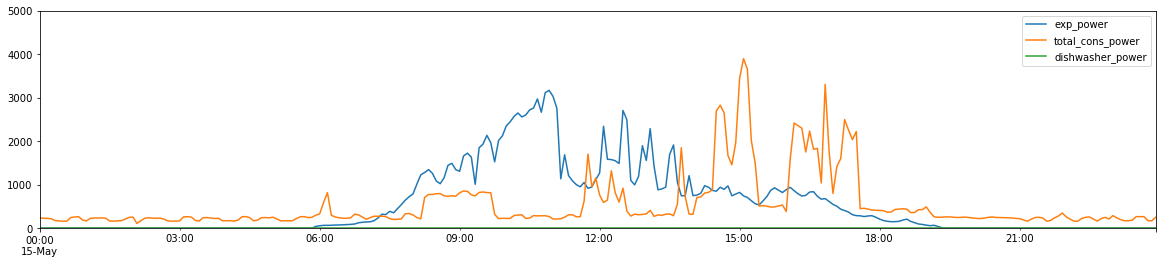

In [27]:
test_day_df.plot(y=['exp_power', 'total_cons_power', appliance_column], figsize=(20, 4), ylim=(0, 5000))

In [28]:
appliance_series = test_day_df[appliance_column]
print(len(appliance_series))

288


## Battery simulation

In [29]:
max_energy = 16000 # Wh 
max_charge = 2000 # W
phi_charge = 0.98
max_drain = -2000 # W
phi_drain = 0.98

In [30]:
energy_flows = (input_df['exp_power'] - input_df['total_cons_power'])   

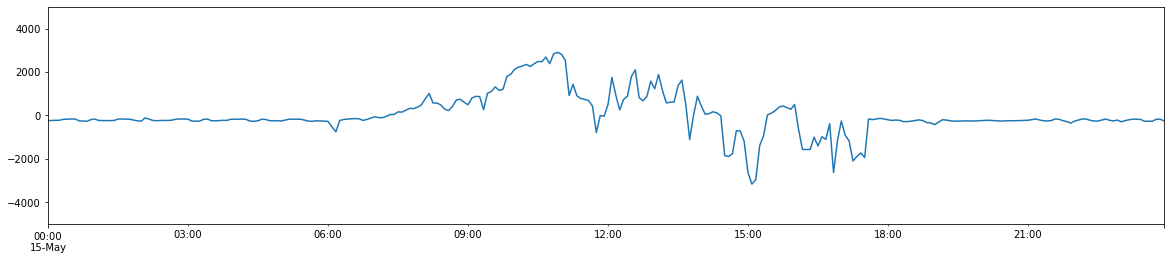

In [31]:
energy_flows[test_day].plot(figsize=(20, 4), ylim=(-5000, 5000))

In [32]:
energy_flows[energy_flows>0] *= phi_charge
energy_flows[energy_flows<0] /= phi_drain
energy_flows[energy_flows>max_charge] = max_charge
energy_flows[energy_flows<max_drain] = max_drain

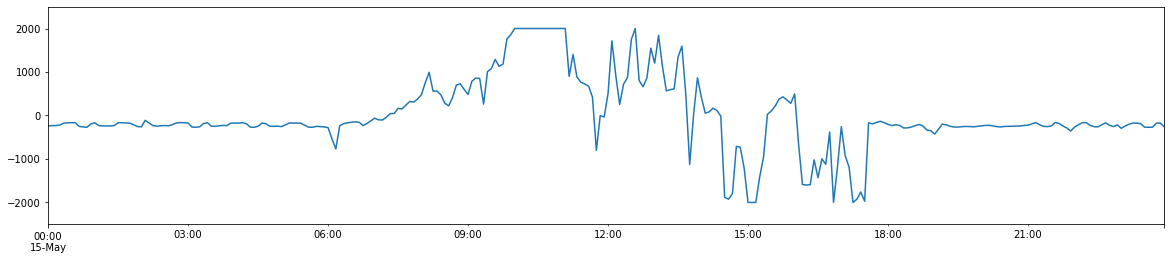

In [33]:
energy_flows[test_day].plot(figsize=(20, 4), ylim=(-2500, 2500))

In [34]:
energy = energy_flows*5/60
for i,x in enumerate(energy.values):
    energy[i] = max(0, min(x + energy[i-1], max_energy)) if i != 0 else 0

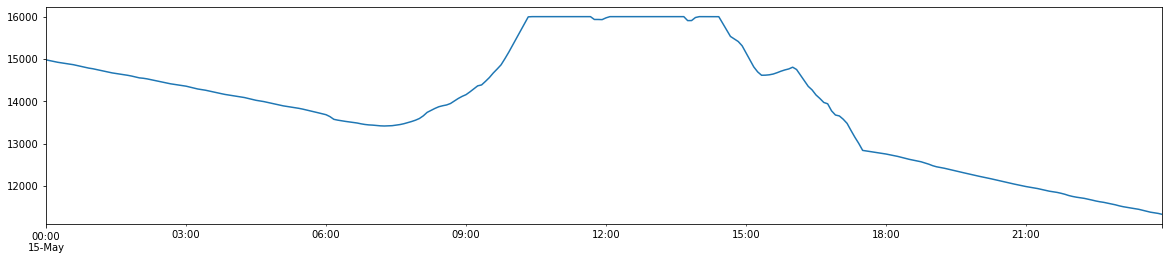

In [35]:
energy[test_day].plot(figsize=(20, 4))

In [36]:
energy_flows = energy.diff()
energy_flows = energy_flows/5*60
energy_flows[energy_flows>0] /= phi_charge
energy_flows[energy_flows<0] *= phi_drain

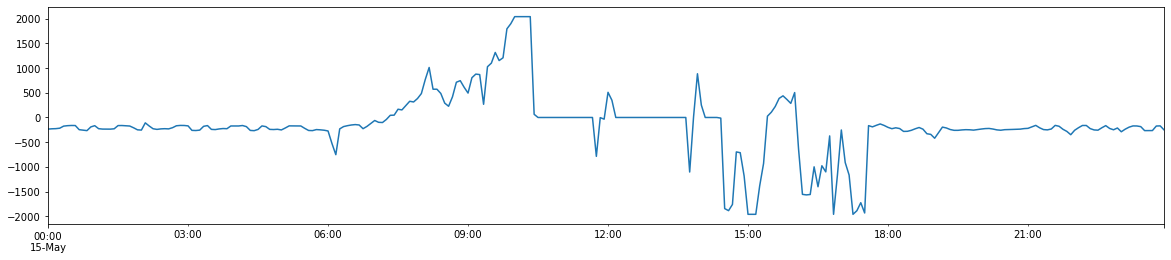

In [37]:
energy_flows[test_day].plot(figsize=(20, 4))

In [38]:
def battery_usage(df,max_energy,max_charge,phi_charge,max_drain,phi_drain):
    """
    df:
    """
    max_energy = max_energy/(5/60*1) # 5min*1h/60min
    energy = (df['exp_power'] - df['total_cons_power'])
    energy[energy>0] *= phi_charge
    energy[energy<0] /= phi_drain
    energy = energy.clip(upper=max_charge,lower=max_drain)
    for i in tqdm(range(len(energy))):
        energy[i] = max(0, min(energy[i] + energy[i-1], max_energy)) if i is not 0 else 0
    energy_flows = energy.diff()
    energy_flows[0] = 0
    energy_flows[energy_flows>0] /= phi_charge
    energy_flows[energy_flows<0] *= phi_drain
    out_df = pd.concat([energy*5/60,energy_flows],axis=1)
    out_df.columns = ['energy','energy_flow']
    return out_df

In [39]:
def test_simulation(df, battary_df):
    compens_power =  battary_df['energy_flow'].clip(upper=0)*(-1)
    unused_pv = (df['exp_power'] - df['total_cons_power']).clip(lower=0)
    print('{}% of the unused PV-Power got accesabel'.format(np.round(compens_power.sum()/unused_pv.sum()*100,1)))
    print('{}% of the total energy usage got compensated'.format(np.round(compens_power.sum()/input_df['total_cons_power'].sum()*100,1)))

In [40]:
result = battery_usage(input_df,max_energy,max_charge,phi_charge,max_drain,phi_drain)

100%|███████████████████████████████████████████████████████████████████████| 279937/279937 [00:25<00:00, 11007.69it/s]


In [41]:
test_simulation(input_df,result)

56.6% of the unused PV-Power got accesabel
29.4% of the total energy usage got compensated


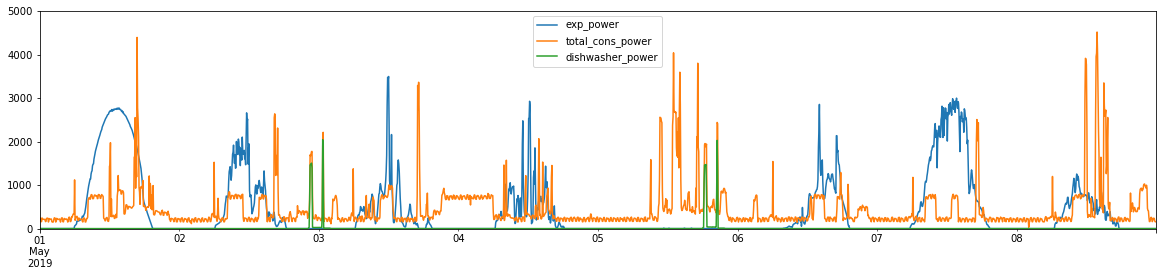

In [42]:
input_df['2019-05-01':'2019-05-08'].plot(y=['exp_power', 'total_cons_power', appliance_column], figsize=(20, 4), ylim=(0, 5000))

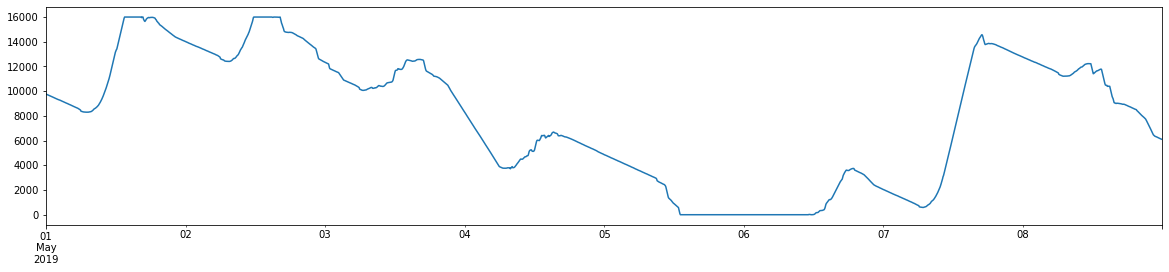

In [43]:
result['energy']['2019-05-01':'2019-05-08'].plot(figsize=(20, 4))

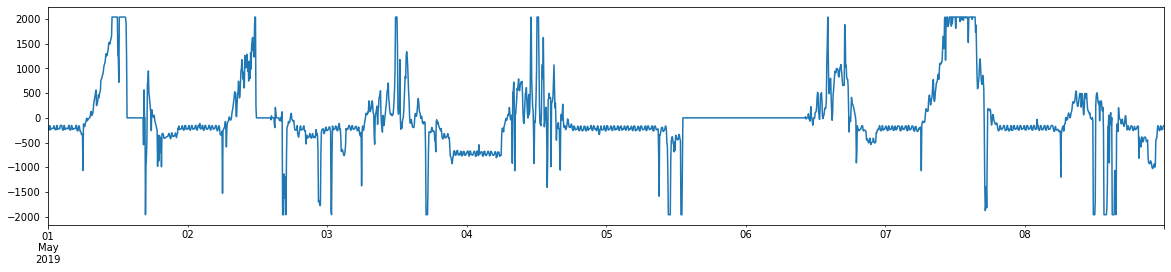

In [44]:
result['energy_flow']['2019-05-01':'2019-05-08'].plot(figsize=(20, 4))

### calculate with pv method

In [45]:
data_dir = os.path.abspath('../data')
max_energy = 6000 # Wh usable energy-capacity of the battery 
max_charge = 3000 # W 
phi_charge = 0.95
max_drain = -3000 # W
phi_drain = 0.96
results, file_names = get_battery_simulation(data_dir,max_energy,max_charge,phi_charge,max_drain,phi_drain)

  1%|▍                                                                        | 1092/166177 [00:00<00:15, 10916.97it/s]

dfA_300s.hdf


100%|███████████████████████████████████████████████████████████████████████| 166177/166177 [00:15<00:00, 10776.02it/s]


74.5% of the unused PV-Power got accesabel
14.7% of the total energy usage got compensated

dfB_300s.hdf
contains already a battery
dfC_300s.hdf


  0%|                                                                                       | 0/343873 [00:00<?, ?it/s]

contains already a battery
dfD_300s.hdf


  0%|                                                                                       | 0/279937 [00:00<?, ?it/s]

22.7% of the unused PV-Power got accesabel
16.6% of the total energy usage got compensated

dfE_300s.hdf


100%|███████████████████████████████████████████████████████████████████████| 279937/279937 [00:26<00:00, 10388.30it/s]


48.4% of the unused PV-Power got accesabel
25.2% of the total energy usage got compensated



### real battery for evaluation of parameters 

In [46]:
data_path = os.path.join(data_dir, 'dfB_300s.hdf')
raw_input_df = pd.read_hdf(data_path)
column_mapping = {}
for c in raw_input_df.columns:
    if c in column_mapping:
        continue
    m = re.match(r'^[A-Z]_(\w+)$', c)
    if m is None:
        raise RuntimeError('Unsupported column name format {}. You will have to map the column manually.'.format(c))
    if m[1] == 'prod_power':
        column_mapping[c] = 'exp_power'
    else:
        column_mapping[c] = m[1]
input_df = raw_input_df.rename(columns=column_mapping)
print(input_df.columns)
test_day = '2019-07-10'
test_day1 = '2019-07-15'

Index(['batt_state', 'boilertemp_bottom', 'boilertemp_top',
       'boiler_heater_1_on', 'boiler_heater_2_on', 'boiler_heater_3_on',
       'boiler_on_thermostat', 'boiler_power', 'direct_cons_power',
       'from_batt_power', 'from_net_power', 'pv_prod_power',
       'total_cons_power', 'to_batt_power', 'to_net_power'],
      dtype='object')


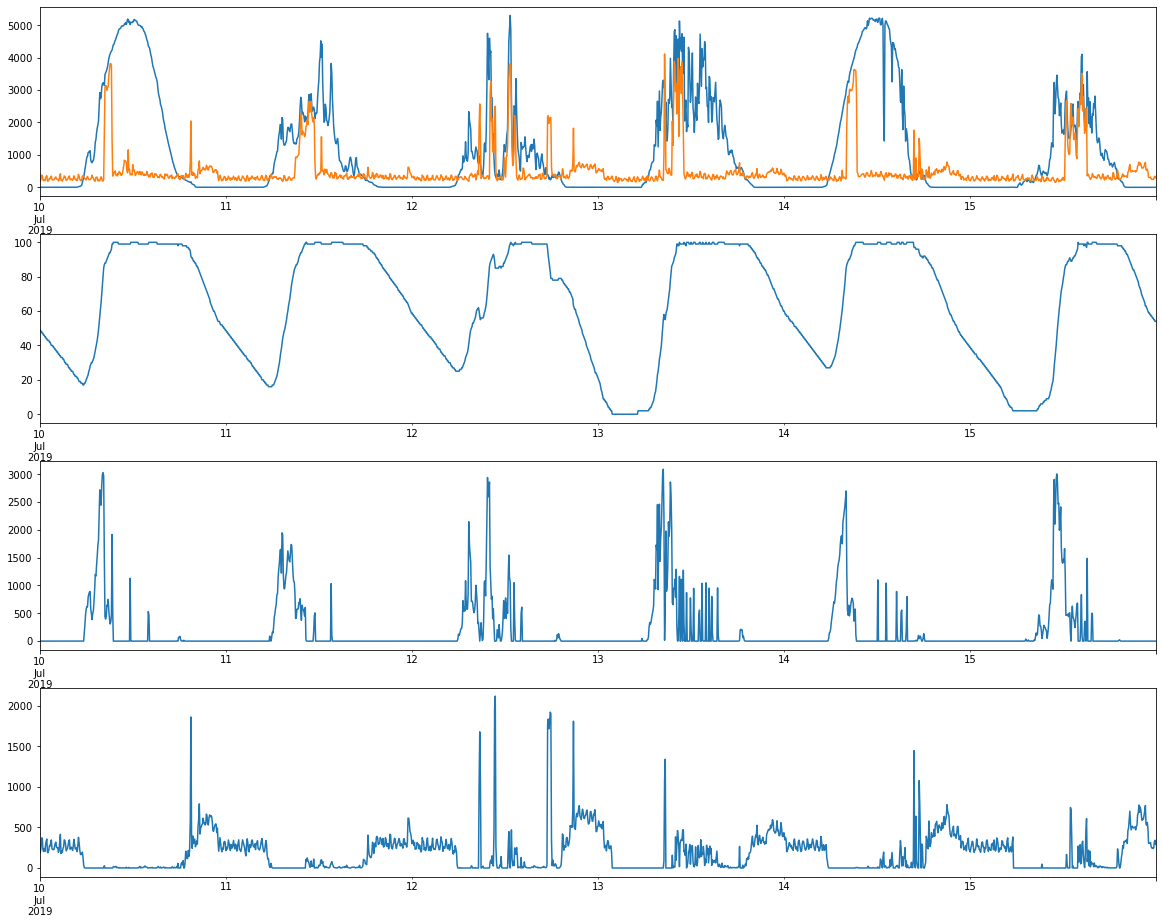

In [47]:
fig,ax= plt.subplots(nrows=4,ncols=1,figsize=(20, 16))
input_df['pv_prod_power'][test_day:test_day1].plot(ax=ax[0])
input_df['total_cons_power'][test_day:test_day1].plot(ax=ax[0])
input_df['batt_state'][test_day:test_day1].plot(ax=ax[1])
input_df['to_batt_power'][test_day:test_day1].plot(ax=ax[2])
input_df['from_batt_power'][test_day:test_day1].plot(ax=ax[3])

In [48]:
energy = input_df[test_day:test_day1]['to_batt_power'][test_day:test_day1].add(input_df['from_batt_power']*(-1)).cumsum()*5/60 # 

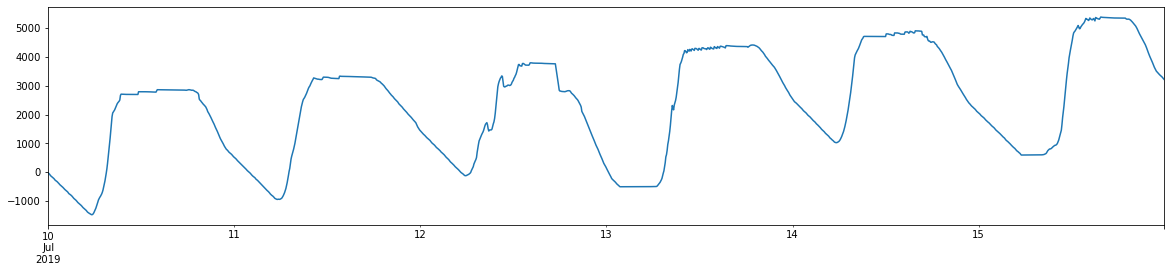

In [49]:
energy[test_day:test_day1].plot(figsize=(20,4))

capacity lies around 5000 Wh

In [50]:
input_df['from_batt_power'].max()

3265.68

In [51]:
input_df['to_batt_power'].max()

4219.8